In [1]:
%matplotlib inline
%reload_ext autoreload

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

FORMAT = "%(asctime)s %(message)s"

logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")
sns.set_context("talk")

In [3]:
epoch_key = 'Jaq', 3, 12

In [4]:
from src.load_data import load_data


data = load_data(epoch_key,
                 position_to_linearize=['nose_x', 'nose_y'],
                 max_distance_from_well=30,
                 min_distance_traveled=50,
                 )

14-Feb-22 15:15:39 Loading position info...
14-Feb-22 15:16:30 Loading multiunit...
14-Feb-22 15:16:53 Loading spikes...
14-Feb-22 15:17:00 Finding ripple times...


In [5]:
import numpy as np

detector_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.5,
    'spike_model_knot_spacing': 12.5,
    'spike_model_penalty': 1E-5,
    'movement_state_transition_type': 'random_walk',
    'multiunit_model_kwargs': {
        'mark_std': 20.0, 'position_std': 8.0, 'block_size': 100},
    'discrete_state_transition_type': 'constant',
    'discrete_diagonal': np.array([0.00003, 0.968])
}

In [6]:
from replay_identification import ReplayDetector
from src.parameters import WTRACK_EDGE_ORDER, WTRACK_EDGE_SPACING


replay_detector = ReplayDetector(**detector_parameters)
logging.info(replay_detector)

is_training = ~data['is_ripple'].values.squeeze()

replay_detector.fit(
    is_ripple=data['is_ripple'],
    is_training=is_training,
    speed=data['position_info'].nose_vel,
    position=data['position_info'].linear_position,
    spikes=data['spikes'],
    track_graph=data['track_graph'],
    edge_order=WTRACK_EDGE_ORDER,
    edge_spacing=WTRACK_EDGE_SPACING,
    use_gpu=True,
)

results = replay_detector.predict(
    speed=data['position_info'].nose_vel,
    position=data['position_info'].linear_position,
    spikes=data['spikes'],
    time=data['position_info'].index / np.timedelta64(1, 's'),
    use_likelihoods=['spikes'],
    use_acausal=True,
    set_no_spike_to_equally_likely=True,
    use_gpu=False,
)
logging.info('Done!')

14-Feb-22 15:17:40 ReplayDetector(discrete_diagonal=array([3.00e-05, 9.68e-01]),
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_type='random_walk', movement_var=6...
               multiunit_model_kwargs={'block_size': 100, 'mark_std': 20.0,
                                       'position_std': 8.0},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.5, position_range=None, replay_speed=1,
               replay_state_transition_penalty=1e-05, speed_knots=None,
               speed_threshold=4.0, spike_mode

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

neurons:   0%|          | 0/121 [00:00<?, ?it/s]

14-Feb-22 15:26:25 Finding causal non-local probability and position...
14-Feb-22 15:26:34 Finding acausal non-local probability and position...
14-Feb-22 15:27:08 Done!


In [7]:
def plot_place_field(detector, neuron_ind=0, ax=None):
    if ax is None:
        ax = plt.gca()
    place_conditional_intensity = (
        detector._spiking_likelihood
        .keywords['place_conditional_intensity']).squeeze().copy()
    is_track_interior = detector.is_track_interior_
    place_conditional_intensity[~is_track_interior] = np.nan
    plt.plot(detector.place_bin_centers_,
             place_conditional_intensity[:, neuron_ind] * 500)

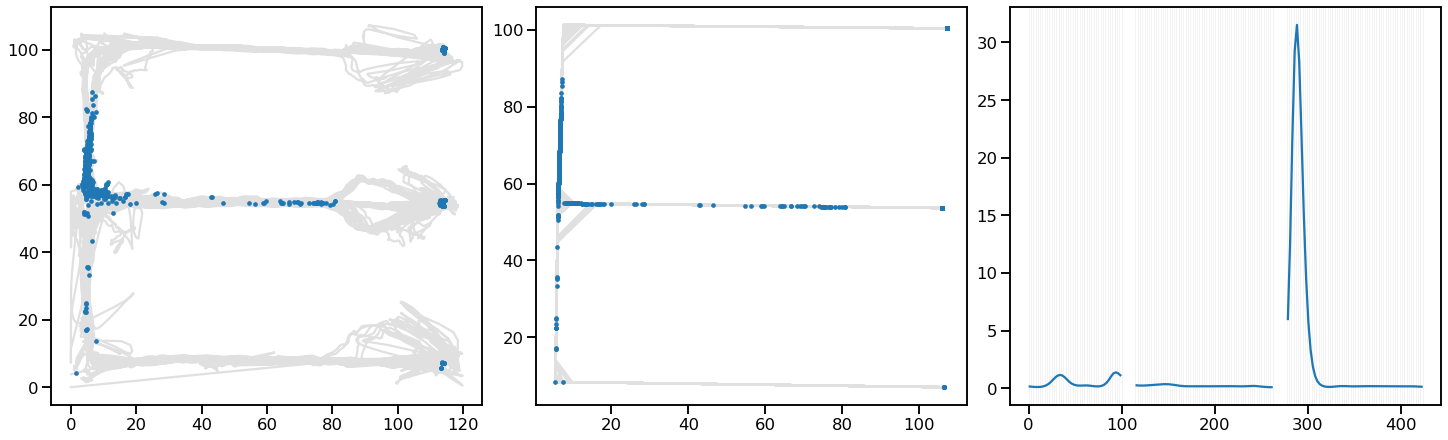

In [10]:
from loren_frank_data_processing import get_spikes_dataframe
from src.parameters import ANIMALS
from src.load_data import get_position_info

neuron_ind = 41

is_spike = data['spikes'].loc[:, data['neuron_info'].iloc[neuron_ind].neuron_id].values.astype(bool)
position = data['position_info'][['nose_x', 'nose_y']].values
projected_position = data['position_info'][['projected_x_position', 'projected_y_position']].values


fig, axes = plt.subplots(1, 3, constrained_layout=True, figsize=(20, 6))
axes[0].plot(position[:, 0], position[:, 1], color='lightgrey', alpha=0.7)
axes[0].scatter(position[is_spike, 0], position[is_spike, 1], zorder=10, s=10)

axes[1].plot(projected_position[:, 0], projected_position[:, 1], color='lightgrey', alpha=0.7)
axes[1].scatter(projected_position[is_spike, 0], projected_position[is_spike, 1], zorder=10, s=10)

plot_place_field(replay_detector, neuron_ind=neuron_ind, ax=axes[2])
    
for edge in replay_detector.place_bin_edges_:
    axes[2].axvline(edge, color='lightgrey', zorder=-1, alpha=0.5, linewidth=0.5)
    
spike_times = get_spikes_dataframe(data['neuron_info'].iloc[neuron_ind].name, ANIMALS).index / np.timedelta64(1, 's')

position_info = get_position_info(epoch_key, skip_linearization=True)
position_time = position_info.index / np.timedelta64(1, 's')
position_spike_ind = np.digitize(spike_times, position_time[1:-1])
position = position_info.loc[:, ['nose_x', 'nose_y']].values
spike_positions = position_info.iloc[position_spike_ind].loc[:, ['nose_x', 'nose_y']].values

In [16]:
place_fields = (
    replay_detector._spiking_likelihood
    .keywords['place_conditional_intensity']).squeeze().copy()

np.argsort(np.argmax(place_fields, axis=0))

array([ 73, 108, 111,  85, 112,  88,  23, 118,   2,  40,  94,  64, 114,
        97,  11,  14,  47,  72,  29,  39,  24,  89,   7,  13,  62, 106,
        34,  66,  76,  57, 109,  68,  18,  53,  61,  84,  38,  74, 110,
        42,  58,  99, 101,  28,  80,  44, 104,   1, 103,  37,  93,  30,
        27,  22,  25,  46,  17,  12,  78,  59,  16,  15, 119,  70,  60,
         4,  71, 105,  79,  95,  49,  26,  56,  21,  87,  96,  65,  33,
        67,  63,   8,  36,  77,   9,  51,  43,  81, 107,   0,  35,  19,
        41,  50,   5,  75,  54,  91,  82, 117,  55,  31,  48,  20,  92,
        90,  83,  32,   6,  10, 115,   3,  69,  52,  98, 100, 102, 116,
        45, 113,  86, 120])

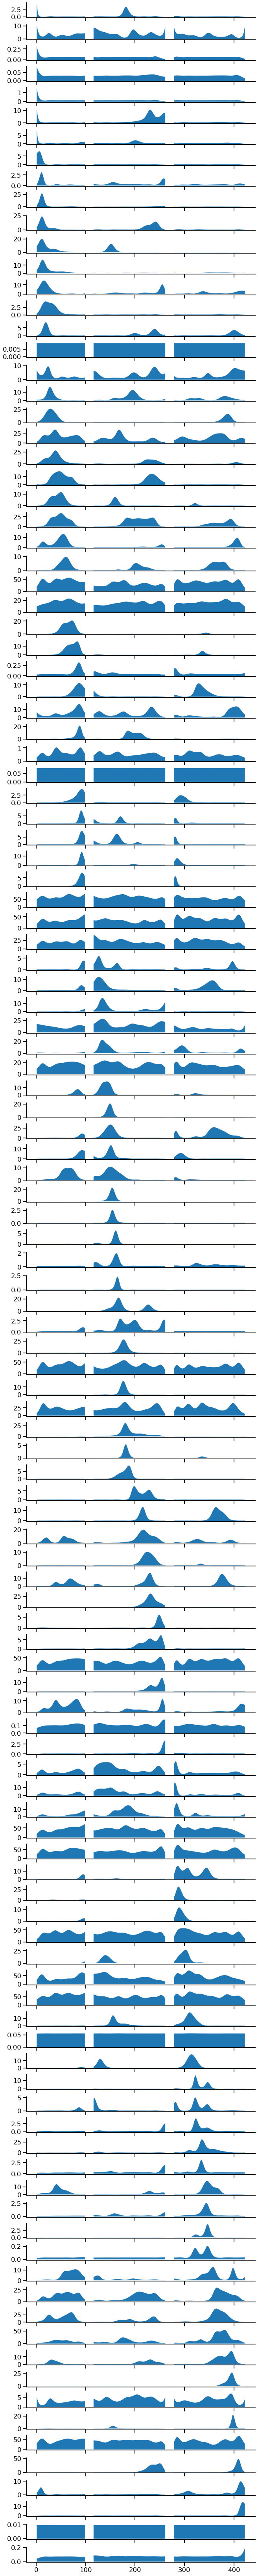

In [17]:
import seaborn as sns


def plot_place_fields(detector, iteration=-1):
    place_fields = (
        detector._spiking_likelihood
        .keywords['place_conditional_intensity']).squeeze().copy()
    is_track_interior = detector.is_track_interior_
    place_fields[~is_track_interior] = np.nan
    sort_id = np.argsort(np.nanargmax(place_fields, axis=0))
    place_fields = place_fields[:, sort_id]
    
    n_neurons = place_fields.shape[1]
    fig, axes = plt.subplots(n_neurons, 1, figsize=(9, 0.75 * n_neurons),
                             sharex=True, constrained_layout=True)

    for neuron_ind, ax in enumerate(axes.flat):
        ax.fill_between(detector.place_bin_centers_.squeeze(),
                        place_fields[:, neuron_ind] * 500, alpha=1)
    sns.despine()
    
    
plot_place_fields(replay_detector)